In [1]:
import argparse
import os
import numpy as np
import math
import sys
import torch
import torch.distributions as distributions
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from scipy.io import savemat
import scipy.io as sio
import sys
import importlib
import datetime
import itertools
import pickle
import scipy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [2]:
data_dir = "data/case30"
case_dir = os.path.join(data_dir)
number = 20000
train_index = 12000
valid_index = 16000
saveFile = "data/case30/RNN_LR/S3"

In [3]:
#input data
mat_input = os.path.join(case_dir, 'inputdata_sample.mat')
PQ_injection = np.transpose(scipy.io.loadmat(mat_input)['sampledata'])[0:number,:]
P_injection = PQ_injection.real
Q_injection = PQ_injection.imag
# print(Q_injection.shape)
pv = [1-1,2-1,13-1,22-1,23-1,27-1]
slack = 1-1
P_injection = np.delete(P_injection,slack,1)
Q_injection = np.delete(Q_injection,pv,1)
# print(Q_injection.shape)
PQ_injection = np.concatenate([P_injection, Q_injection], axis=1)       
print(PQ_injection.shape)
#output data
mat_ang = os.path.join(case_dir, 'voltage_ang_reduced.mat')
mat_mag = os.path.join(case_dir, 'voltage_mag_reduced.mat')
voltage_ang = np.transpose(scipy.io.loadmat(mat_ang)['voltage_ang_reduced'])[0:number,:]
voltage_mag = np.transpose(scipy.io.loadmat(mat_mag)['voltage_mag_reduced'])[0:number,:]
voltage =  np.concatenate([voltage_ang,voltage_mag], axis=1) 
yTrain = torch.from_numpy(voltage[0:train_index,:])
xTrain = torch.from_numpy(PQ_injection[0:train_index,:])
yValid = torch.from_numpy(voltage[train_index:valid_index,:])
xValid = torch.from_numpy(PQ_injection[train_index:valid_index,:])
yTest = torch.from_numpy(voltage[valid_index:number,:])
xTest = torch.from_numpy(PQ_injection[valid_index:number,:])
dataset = torch.utils.data.TensorDataset(xTrain, yTrain)
print(xValid.shape)
print(xTrain.shape)
print(xTest.shape)

(20000, 53)
torch.Size([4000, 53])
torch.Size([12000, 53])
torch.Size([4000, 53])


In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=32, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0001, help="learning rate")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--labels_dim", type=int, default=53, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=53, help="size of each image dimension")
parser.add_argument("--hidden1_dim", type=int, default=100, help="size of hidden_dim")
parser.add_argument("--output1_dim", type=int, default=100, help="size of hidden_dim")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, hidden1_dim=100, img_size=53, labels_dim=53, lr=1e-05, n_cpu=8, n_epochs=400, output1_dim=100)


In [5]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
#reg = LinearRegression().fit(xTrain, yTrain)
reg = Ridge(alpha = 0.0001).fit(xTrain, yTrain)
initial_weight_original = reg.coef_
initial_bias_original = reg.intercept_
initial_weight = Tensor(initial_weight_original)
initial_bias = Tensor(initial_bias_original)

In [6]:
print(initial_bias.shape)
print(initial_weight.shape)

torch.Size([53])
torch.Size([53, 53])


In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_feat, hidden_feat, out_feat):
        super(BasicBlock, self).__init__()
        self.layers = nn.Linear(opt.labels_dim, opt.img_size)
        self.layers1 = nn.Linear(opt.labels_dim, hidden_feat)
        self.relu = nn.ReLU(inplace=True)
        self.layers2 = nn.Linear(hidden_feat, hidden_feat)
        self.layers3 = nn.Linear(hidden_feat, out_feat)
        self.layers.weight = torch.nn.Parameter(initial_weight)
        self.layers.bias = torch.nn.Parameter(initial_bias)
    def forward(self, x):
        identity = self.layers(x)

        out = self.layers1(x)
        out = self.relu(out)

        out = self.layers2(out)
        out = self.relu(out)
        
        out = self.layers3(out)
        out = identity + out
        #out = self.relu(out)

        return out
class Resnet(nn.Module):
    def __init__(self, block):
        super(Resnet, self).__init__()
        self.block = block
        self.model = nn.Sequential(
            block(opt.labels_dim,opt.hidden1_dim, opt.img_size),
            #block(opt.output1_dim,opt.hidden2_dim,opt.output2_dim),
            #block(opt.output1_dim,opt.hidden2_dim,opt.output2_dim),
            #nn.Linear(opt.output1_dim,opt.img_size),
        )   
    def forward(self, x):
        out = self.model(x)
        return out
MLP = Resnet(BasicBlock)

In [ ]:
y_TestHat = MLP.model[0].layers(xTest.float())
rmse_test = torch.sqrt(torch.mean((y_TestHat - yTest.float())**2,axis = 0))
rmse_ang_test = torch.mean(rmse_test[0:29])
rmse_mag_test = torch.mean(rmse_test[29:53])
print(rmse_ang_test)
print(rmse_mag_test)

In [ ]:
# Initialize generator and discriminator
time = []
loss_train = []  
loss_valid = [] 
batch_loss_train = [] 
avg_train_losses = []
L2_loss = nn.MSELoss()
if cuda:
    MLP.cuda()
    L2_loss.cuda()
# Configure data loader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer = torch.optim.Adam(MLP.parameters(), lr=opt.lr)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
# Create batch of latent vectors that we will use to check the progression of the generator
# ----------
#  Training
# ----------

batches_done = 0

for epoch in range(opt.n_epochs):

    for i, (xTrain, yTrain) in enumerate(dataloader):
        # Configure input
            # -----------------
            #  Train Generator
            # -----------------
            startTime = datetime.datetime.now()
            optimizer.zero_grad()
            # Generate a batch of images
            yHatTrain = MLP(xTrain.float())
            # Adversarial loss
            loss = L2_loss(yHatTrain,yTrain.float())
            loss.backward()
            optimizer.step()
            endTime = datetime.datetime.now()
            timeElapsed = abs(endTime - startTime).total_seconds()
            time.append(timeElapsed)
            batch_loss_train.append(loss.item())  
            print(
                "[Epoch %d/%d] [Batch %d/%d][G loss: %.9f]"
                % (epoch, opt.n_epochs, batches_done % len(dataloader), len(dataloader), loss.item())
            )       
            if (batches_done % (len(yValid)//opt.batch_size) == 0):
                with torch.no_grad(): 
                    yHatValid = MLP(xValid.float()) 
                    # Compute loss
                    lossValueValid = L2_loss(yHatValid, yValid)
                    loss_valid.append(lossValueValid.item())
                if epoch >= 799:
                    if (epoch == 799):
                        bestScore = lossValueValid
                        torch.save(MLP.state_dict(), saveFile +'Best'+'.ckpt')
                        torch.save(optimizer.state_dict(), saveFile+'Optim'+'Best'+'.ckpt')
                    else:
                        thisValidScore = lossValueValid
                        if thisValidScore < bestScore:
                            bestScore = thisValidScore
                            torch.save(MLP.state_dict(), saveFile + 'Best'+'.ckpt')
                            torch.save(optimizer.state_dict(), saveFile+'Optim'+'Best'+'.ckpt')                  
            batches_done += 1
    train_loss = np.average(batch_loss_train)
    avg_train_losses.append(train_loss)
    batch_loss_train = []

In [23]:
torch.save(time, saveFile + 'Time')
torch.save(MLP.state_dict(), saveFile + 'Last'+'.ckpt')
torch.save(optimizer.state_dict(), saveFile+'Optim'+'Last'+'.ckpt') 
np.save(saveFile+'Train',avg_train_losses)
np.save(saveFile+'Valid',loss_valid)

In [ ]:
plt.plot(avg_train_losses[200:1000])
plt.ylabel('mean squared loss')
plt.xlabel('epoch')
plt.title('neurons = 200')
plt.show()

In [ ]:
plt.plot(loss_valid[1500:3000:4])
plt.plot(loss_valid[3000:4500:4])
plt.ylabel('mean squared loss')
plt.xlabel('epoch')
plt.show()

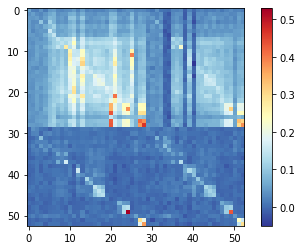

[[ 0.05828424  0.02185371  0.01842796 ...  0.02359192  0.02597785
   0.01951063]
 [ 0.03722832  0.05225526  0.03506538 ...  0.03061008  0.04599512
   0.04030554]
 [ 0.04659604  0.04384759  0.05059697 ...  0.02643303  0.05388037
   0.04053432]
 ...
 [ 0.00863184  0.02202503  0.0078987  ...  0.04428414  0.00922916
   0.00701907]
 [-0.00566256  0.00067742 -0.00591888 ...  0.01032159  0.23695321
   0.16194119]
 [-0.00514005  0.00357475  0.0103602  ...  0.00604989  0.15234019
   0.29528347]]


In [126]:
color_map = plt.imshow(MLP.model[0].layers.weight.detach().numpy())
color_map.set_cmap("RdYlBu_r")
plt.colorbar()
plt.show()
print(MLP.model[0].layers.weight.detach().numpy())

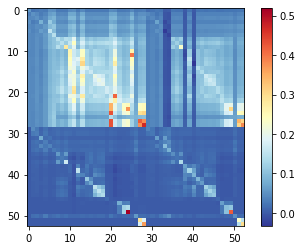

[[ 5.60702089e-02  2.16785491e-02  2.62218316e-02 ...  2.32561582e-02
   2.56339433e-02  2.66821843e-02]
 [ 3.35620765e-02  5.22907896e-02  4.29217272e-02 ...  3.21805468e-02
   3.98188564e-02  4.14456135e-02]
 [ 4.08151181e-02  4.35737460e-02  5.25302890e-02 ...  3.93158016e-02
   4.84957861e-02  5.04807611e-02]
 ...
 [-4.41115840e-04  1.67364230e-02  2.03098215e-02 ...  4.71093064e-02
   1.38145859e-02  1.43984945e-02]
 [-1.17336049e-05 -8.55315764e-05  2.85705797e-04 ... -9.44303201e-05
   2.36257822e-01  1.50996113e-01]
 [-1.00457261e-05 -2.29201666e-05  7.78940855e-05 ... -4.56428140e-05
   1.45595815e-01  2.99263242e-01]]


In [125]:
color_map = plt.imshow(initial_weight_original)
plt.colorbar()
color_map.set_cmap("RdYlBu_r")
plt.show()
print(initial_weight_original)

In [ ]:
#number = 200
MLP.eval()
yHatTest = MLP(xTest.float())
rmse_test = np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2)
print(rmse_test)
rmse_test1 = np.sqrt(np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2,0))
print(rmse_test1)
print(np.mean(rmse_test1[0:29]))
print(np.mean(rmse_test1[29:53]))

In [27]:
np.save(saveFile+'rmse_test_last',rmse_test1)
np.save(saveFile+'yHatTest_last',yHatTest.detach().numpy())

In [ ]:
model = Resnet(BasicBlock)
model.load_state_dict(torch.load(saveFile + 'Best'+'.ckpt'))
optimizer.load_state_dict(torch.load(saveFile+'Optim'+'Best'+'.ckpt'))
model.eval()
yHatTest = model(xTest.float())
rmse_test2 = np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2)
print(rmse_test2)
rmse_test3 = np.sqrt(np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2,0))
print(rmse_test3)
print(np.mean(rmse_test3[0:29]))
print(np.mean(rmse_test3[29:53]))

In [29]:
np.save(saveFile+'rmse_test_best',rmse_test3)
np.save(saveFile+'yHatTest_best',yHatTest.detach().numpy())

In [40]:
np.save(saveFile+'yTest',yTest.detach().numpy())